# Two imputs (N,Z) and 1 outputs (Mass excess) in single ANN

# Imports

In [1]:
import numpy as np
import tensorflow as tf
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
from utils import shuffle_batch, variable_summaries
import os

%matplotlib notebook

dir_path = os.getcwd()

now = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)
print(dir_path)
print(now)

C:\Users\kicjo\Desktop\my-anns\nuclei\nuclei-updated-2-inputs-mass-output
2019-08-20-14-40-32


In [2]:
#%matplotlib notebook

# Read the data set

In [3]:
df = pd.read_csv("better-nuclei-19-08.csv")
print(df.info())
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3436 entries, 0 to 3435
Data columns (total 10 columns):
Z                                  3436 non-null int64
N                                  3436 non-null int64
UQ                                 3436 non-null int64
DQ                                 3436 non-null int64
Mass Excess [MeV]                  3436 non-null float64
Mass Error                         3436 non-null float64
Mass Estimated                     3436 non-null int64
Neutron separation energy [MeV]    3318 non-null float64
Separation Error                   3318 non-null float64
Separation Estimated               3318 non-null float64
dtypes: float64(5), int64(5)
memory usage: 268.5 KB
None


Index(['Z', 'N', 'UQ', 'DQ', 'Mass Excess [MeV]', 'Mass Error',
       'Mass Estimated', 'Neutron separation energy [MeV]', 'Separation Error',
       'Separation Estimated'],
      dtype='object')

In [4]:
df = df.rename(columns=
               {"Mass Excess [MeV]": "d",
                "Z":'z',
                'N':'n',
                'UQ':"uq",
                'DQ':"dq",
                "Mass Error":"mass error",
                "Mass Estimated":"mass estimated",
                "Neutron separation energy [MeV]":"d2",
                "Separation Error":"separation error",
                "Separation Estimated":"separation estimated"               
               })
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3436 entries, 0 to 3435
Data columns (total 10 columns):
z                       3436 non-null int64
n                       3436 non-null int64
uq                      3436 non-null int64
dq                      3436 non-null int64
d                       3436 non-null float64
mass error              3436 non-null float64
mass estimated          3436 non-null int64
d2                      3318 non-null float64
separation error        3318 non-null float64
separation estimated    3318 non-null float64
dtypes: float64(5), int64(5)
memory usage: 268.5 KB
None


In [5]:
df.describe()

,z,n,uq,dq,d,mass error,mass estimated,d2,separation error,separation estimated
count,3436.000000,3436.000000,3436.000000,3436.000000,3436.000000,3436.000000,3436.000000,3318.000000,3318.000000,3318.000000
mean,57.857392,82.034051,197.748836,221.925495,-24.144121,0.123589,0.272992,7.755557,0.164216,0.295660
std,27.809406,43.293558,98.188326,113.771063,56.200706,0.197548,0.445562,3.631747,0.254378,0.456408
min,0.000000,0.000000,1.000000,1.000000,-91.652853,0.000000,0.000000,-2.488000,0.000000,0.000000
25%,36.000000,47.000000,120.750000,131.000000,-65.400443,0.003006,0.000000,5.414787,0.005140,0.000000
50%,58.000000,81.000000,197.000000,219.000000,-39.335024,0.014474,0.000000,7.249960,0.025005,0.000000
75%,80.000000,114.000000,273.000000,308.000000,1.172301,0.196000,1.000000,9.654658,0.269058,1.000000
max,118.000000,177.000000,413.000000,472.000000,201.512000,2.003000,1.000000,27.715000,2.011000,1.000000


# Remove estimated Excess and estimated Seperation

In [6]:
not_estimated_filter = (df["mass estimated"] == 0)
df = df[not_estimated_filter]

not_estimated_filter = (df["separation estimated"] == 0)
df = df[not_estimated_filter]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2337 entries, 0 to 3369
Data columns (total 10 columns):
z                       2337 non-null int64
n                       2337 non-null int64
uq                      2337 non-null int64
dq                      2337 non-null int64
d                       2337 non-null float64
mass error              2337 non-null float64
mass estimated          2337 non-null int64
d2                      2337 non-null float64
separation error        2337 non-null float64
separation estimated    2337 non-null float64
dtypes: float64(5), int64(5)
memory usage: 200.8 KB


In [8]:
df.isnull().values.any()

False

In [9]:
df['z'].shape

(2337,)

In [10]:
df.count()

z                       2337
n                       2337
uq                      2337
dq                      2337
d                       2337
mass error              2337
mass estimated          2337
d2                      2337
separation error        2337
separation estimated    2337
dtype: int64

In [11]:
df.head()

,z,n,uq,dq,d,mass error,mass estimated,d2,separation error,separation estimated
0,0,1,1,2,8.071317,4.000000e-07,0,0.00000,0.00000,0.0
2,1,1,3,3,13.135722,1.000000e-07,0,2.22457,0.00000,0.0
3,1,2,4,5,14.949810,2.000000e-07,0,6.25723,0.00000,0.0
4,1,3,5,7,24.621127,1.000000e-01,0,-1.60000,0.10000,0.0
5,1,4,6,9,32.892444,8.944300e-02,0,-0.20000,0.13416,0.0


# Plot seperation energy column

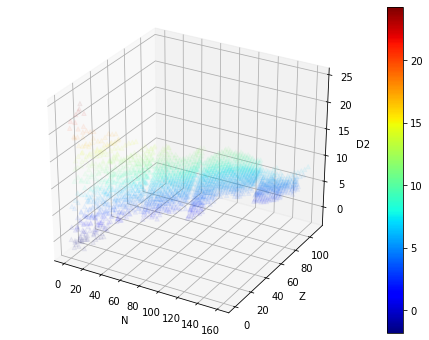

In [12]:
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(111,projection='3d')

xs = df['n']
ys = df['z']
zs = df['d2']

colmap = cm.ScalarMappable(cmap=cm.get_cmap("jet"))
colmap.set_array(zs)

yg = ax.scatter(xs, ys, zs, c=cm.get_cmap("jet")(zs/max(zs)), marker='^',alpha=0.05)
cb = fig.colorbar(colmap)

ax.set_xlabel('N')
ax.set_ylabel('Z')
ax.set_zlabel('D2')


plt.show()

In [13]:
df['d2'].to_numpy().shape

(2337,)

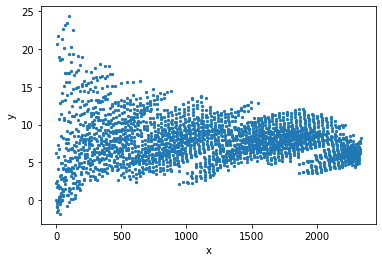

In [14]:
plt.scatter(range(df['d2'].count()), df['d2'].to_numpy(), s=5)
plt.xlabel('x')
plt.ylabel('y')
plt.axis('tight')
plt.show()

# Dividing Mass Excess by A = Z + N

In [15]:
zes = df['z'].to_numpy()
ns = df['n'].to_numpy()
a = zes + ns

des = df['d'].to_numpy() / a
df['d'] = des


# Plot Mass excess output column

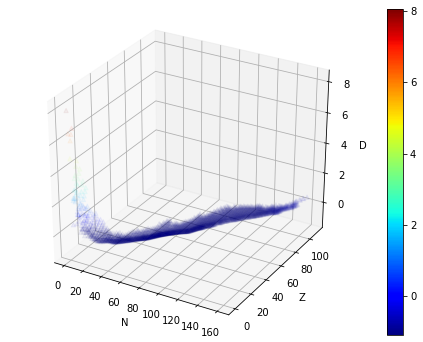

In [16]:
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(111,projection='3d')

xs = df['n']
ys = df['z']
zs = df['d']

colmap = cm.ScalarMappable(cmap=cm.get_cmap("jet"))
colmap.set_array(zs)

yg = ax.scatter(xs, ys, zs, c=cm.get_cmap("jet")(zs/max(zs)), marker='^',alpha=0.05)
cb = fig.colorbar(colmap)

ax.set_xlabel('N')
ax.set_ylabel('Z')
ax.set_zlabel('D')


plt.show()

# Tripcolor

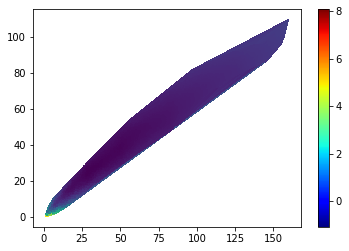

In [17]:
zs = df['d']

colmap = cm.ScalarMappable(cmap=cm.get_cmap("jet"))
colmap.set_array(zs)

#yg = ax.scatter(xs, ys, zs, c=cm.get_cmap("jet")(zs/max(zs)), marker='^',alpha=0.05)


fig, (ax)=plt.subplots(ncols=1)
ax.tripcolor(df["n"], df["z"], df["d"])
cb = fig.colorbar(colmap)

plt.show()

# Set X inputs

In [18]:
x = df[['z','n']]
print(x.info())
x = x.to_numpy()
print(x.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2337 entries, 0 to 3369
Data columns (total 2 columns):
z    2337 non-null int64
n    2337 non-null int64
dtypes: int64(2)
memory usage: 54.8 KB
None
(2337, 2)


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2337 entries, 0 to 3369
Data columns (total 10 columns):
z                       2337 non-null int64
n                       2337 non-null int64
uq                      2337 non-null int64
dq                      2337 non-null int64
d                       2337 non-null float64
mass error              2337 non-null float64
mass estimated          2337 non-null int64
d2                      2337 non-null float64
separation error        2337 non-null float64
separation estimated    2337 non-null float64
dtypes: float64(5), int64(5)
memory usage: 200.8 KB


# Set Y inputs _(HERE CHANGE NUMBER OF INPUTS AND RESHAPE)

In [20]:
y = df[['d']].to_numpy() #HERE
y.shape

(2337, 1)

In [21]:
y = y.reshape(-1,1) #HERE
y.shape

(2337, 1)

In [22]:
y[0:5]

array([[8.07131713],
       [6.56786088],
       [4.98326998],
       [6.15528175],
       [6.5784888 ]])

# Prepare X_train_o, Y_train_o etc

In [23]:
X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(x, y, test_size=0.2, random_state=1)
X_train_o, X_val_o, y_train_o, y_val_o  = train_test_split(X_train_o, y_train_o, test_size=0.2, random_state=1)
n_inputs = X_train_o.shape[1]
n_outputs = y_train_o.shape[1]
print(n_inputs)
print(n_outputs)
print(X_train_o.shape, X_test_o.shape,X_val_o.shape)

2
1
(1495, 2) (468, 2) (374, 2)


# Scaling

In [24]:
x_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train = x_scaler.fit_transform(X_train_o.reshape(-1, n_inputs))
X_test = x_scaler.transform(X_test_o.reshape(-1, n_inputs))
X_val = x_scaler.transform(X_val_o.reshape(-1, n_inputs))

y_train = y_scaler.fit_transform(y_train_o.reshape(-1, n_outputs))
y_test = y_scaler.transform(y_test_o.reshape(-1, n_outputs))
y_val = y_scaler.transform(y_val_o.reshape(-1, n_outputs))

n_inputs = X_train.shape[1]
n_outputs = y_train.shape[1]
print(n_inputs)
print(n_outputs)

2
1


# ANN TOPOLOGY

In [25]:
def cust_layer(inputs,number_of_neurons, name, activation=None, dropout=False):
    init = tf.initializers.he_normal(seed=None)
    hidden = tf.keras.layers.Dense(number_of_neurons,
                                   name=name,
                                    kernel_initializer=init,
                                   activation = activation,
                                   kernel_regularizer = tf.keras.regularizers.l2(l=0.1)
                                  )(inputs)
    
    batch_norm = tf.keras.layers.BatchNormalization()(hidden, training=True)
    
    if dropout:
        dropout_layer = tf.keras.layers.Dropout(0.5)(batch_norm)
        return dropout_layer
    else:
        return batch_norm
    
tf.reset_default_graph()
with tf.name_scope("dnn"):
    with tf.name_scope("inputs"):
        X_node = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
        y_node = tf.placeholder(tf.float32, shape=(None, n_outputs), name="y")
    
    last_layer = cust_layer(X_node,50,"hidden1")    
    n_layers = 10
    
    for i in range(n_layers):      
            
        last_layer = cust_layer(last_layer,150,"hidden"+str(i),activation=tf.nn.elu,dropout=True)
    last_layer = cust_layer(last_layer,50,"hidden"+str(i+1),activation=tf.nn.elu,dropout=True)
    
    init = tf.initializers.he_normal()    
    y_pred = tf.keras.layers.Dense(n_outputs, name="output",kernel_initializer=init)(last_layer)

    
with tf.name_scope('MSE'):
    error_f = y_pred - y_node
    square_f = tf.square(error_f)
    mse = tf.reduce_mean(square_f, name="mse_first")
    variable_summaries(mse)
    print(error_f.get_shape())


with tf.name_scope('optimiser'):
    optimiser = tf.train.AdamOptimizer(0.01)
    training_op = optimiser.minimize(mse)

for var in tf.trainable_variables():
    tf.summary.histogram(var.name, var)

W0820 14:40:35.262200  9452 deprecation_wrapper.py:119] From C:\Users\kicjo\Desktop\my-anns\nuclei\nuclei-updated-2-inputs-mass-output\utils.py:16: The name tf.summary.scalar is deprecated. Please use tf.compat.v1.summary.scalar instead.

W0820 14:40:35.288257  9452 deprecation_wrapper.py:119] From C:\Users\kicjo\Desktop\my-anns\nuclei\nuclei-updated-2-inputs-mass-output\utils.py:22: The name tf.summary.histogram is deprecated. Please use tf.compat.v1.summary.histogram instead.



(?, 1)


# File writers

In [26]:
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(logdir + '/train', tf.get_default_graph())
test_writer = tf.summary.FileWriter(logdir + '/test')
valid_writer = tf.summary.FileWriter(logdir + '/valid')
init = tf.global_variables_initializer()

saver = tf.train.Saver()

checkpoint_path = os.path.join(dir_path, "sinus_tmp","sinus_full_model.ckpt")
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = os.path.join(dir_path, "model", "my_sinus_full_model")

# Number of epochs and batches

In [27]:
n_epochs = 2000
n_batches = 50

best_loss = np.infty
epochs_without_progress = 0
max_epochs_without_progress = n_epochs * 0.2
print(max_epochs_without_progress)



400.0


# Training

In [28]:
with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        # if the checkpoint file exists, restore the model and load the epoch number
        with open(checkpoint_epoch_path, "rb") as f:
            start_epoch = int(f.read())
        print("Training was interrupted. Continuing at epoch", start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        sess.run(init)

    for epoch in range(start_epoch, n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, n_batches):
            summary, _ = sess.run([merged, training_op],
                                  feed_dict={X_node: X_batch, y_node: y_batch})

        train_summary, _ = sess.run([merged, training_op],feed_dict={X_node: X_train, y_node: y_train})
        test_summary, _ =sess.run([merged, training_op],feed_dict={X_node: X_test, y_node: y_test})
        validation_summary, _ = sess.run([merged, training_op], feed_dict={X_node: X_val, y_node: y_val})

        train_writer.add_summary(train_summary, epoch)
        test_writer.add_summary(test_summary, epoch)
        valid_writer.add_summary(validation_summary,epoch)

        loss_train = mse.eval(feed_dict={X_node: X_train, y_node: y_train})
        loss_val = mse.eval(feed_dict={X_node: X_val, y_node: y_val})
        print(epoch, "train loss:", loss_train, "valid loss:", loss_val)

        iteration_skip = 10
        if epoch % iteration_skip == 0:
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch + 1))

        if loss_val < best_loss:
            saver.save(sess, final_model_path)
            best_loss = loss_val
            print("best loss:", best_loss)
            epochs_without_progress = 0
        else:
            epochs_without_progress += 1
            if epochs_without_progress > max_epochs_without_progress:
                print("Early stopping")
                break


train_writer.close()
test_writer.close()
valid_writer.close()

0 train loss: 0.3173225 valid loss: 0.49884626
best loss: 0.49884626
1 train loss: 0.28555617 valid loss: 0.41609234
best loss: 0.41609234
2 train loss: 0.10816195 valid loss: 0.1812302
best loss: 0.1812302
3 train loss: 0.10574479 valid loss: 0.16294345
best loss: 0.16294345
4 train loss: 0.10393577 valid loss: 0.15169187
best loss: 0.15169187
5 train loss: 0.25134113 valid loss: 0.38550147
6 train loss: 0.16601972 valid loss: 0.249489
7 train loss: 0.10982778 valid loss: 0.16801107
8 train loss: 0.15751071 valid loss: 0.25148642
9 train loss: 0.10630785 valid loss: 0.18044192
10 train loss: 0.12171735 valid loss: 0.2035235
11 train loss: 0.055167876 valid loss: 0.0884345
best loss: 0.0884345
12 train loss: 0.26721606 valid loss: 0.3880176
13 train loss: 0.1167383 valid loss: 0.21149617
14 train loss: 0.06593986 valid loss: 0.13235798
15 train loss: 0.19188476 valid loss: 0.32415748
16 train loss: 0.087606356 valid loss: 0.13241279
17 train loss: 0.17426734 valid loss: 0.29667422
18 t

164 train loss: 0.05777344 valid loss: 0.12609807
165 train loss: 0.068692066 valid loss: 0.14921547
166 train loss: 0.09340658 valid loss: 0.18243933
167 train loss: 0.063464 valid loss: 0.13822575
168 train loss: 0.16335163 valid loss: 0.24069168
169 train loss: 0.10412231 valid loss: 0.19270892
170 train loss: 0.08990856 valid loss: 0.14359806
171 train loss: 0.10744184 valid loss: 0.18770273
172 train loss: 0.07215741 valid loss: 0.14818245
173 train loss: 0.08434019 valid loss: 0.15842205
174 train loss: 0.0868972 valid loss: 0.1814301
175 train loss: 0.08826196 valid loss: 0.18556905
176 train loss: 0.05862534 valid loss: 0.13226284
177 train loss: 0.06842966 valid loss: 0.1537829
178 train loss: 0.08395321 valid loss: 0.1681531
179 train loss: 0.07412232 valid loss: 0.16367976
180 train loss: 0.07543483 valid loss: 0.15257867
181 train loss: 0.07900741 valid loss: 0.14619829
182 train loss: 0.07230406 valid loss: 0.15149488
183 train loss: 0.046153095 valid loss: 0.10521443
184 

328 train loss: 0.06635035 valid loss: 0.143072
329 train loss: 0.07697564 valid loss: 0.16561145
330 train loss: 0.048280172 valid loss: 0.119073324
331 train loss: 0.08229322 valid loss: 0.13954756
332 train loss: 0.055828065 valid loss: 0.13076441
333 train loss: 0.06830777 valid loss: 0.15408535
334 train loss: 0.0695152 valid loss: 0.14917536
335 train loss: 0.11196646 valid loss: 0.21350235
336 train loss: 0.078771636 valid loss: 0.16047177
337 train loss: 0.10118895 valid loss: 0.18657137
338 train loss: 0.074637115 valid loss: 0.16491131
339 train loss: 0.05708386 valid loss: 0.1257896
340 train loss: 0.062276702 valid loss: 0.1469838
341 train loss: 0.06366848 valid loss: 0.14663099
342 train loss: 0.06827951 valid loss: 0.15366723
343 train loss: 0.09143138 valid loss: 0.16652673
344 train loss: 0.101129845 valid loss: 0.20135926
345 train loss: 0.06640642 valid loss: 0.14516142
346 train loss: 0.06061409 valid loss: 0.14044262
347 train loss: 0.07634659 valid loss: 0.1634409

492 train loss: 0.07332539 valid loss: 0.13409965
493 train loss: 0.06857208 valid loss: 0.14852111
494 train loss: 0.071691856 valid loss: 0.15085492
495 train loss: 0.07421654 valid loss: 0.14328389
496 train loss: 0.07671812 valid loss: 0.14798568
497 train loss: 0.06173255 valid loss: 0.12785335
498 train loss: 0.06767024 valid loss: 0.14035705
499 train loss: 0.06439607 valid loss: 0.1362626
500 train loss: 0.064307824 valid loss: 0.1286135
501 train loss: 0.06362809 valid loss: 0.12970583
502 train loss: 0.061874267 valid loss: 0.12126326
503 train loss: 0.07534713 valid loss: 0.16162106
504 train loss: 0.077160515 valid loss: 0.15959276
505 train loss: 0.055638846 valid loss: 0.12648861
506 train loss: 0.077181034 valid loss: 0.16343473
507 train loss: 0.07554981 valid loss: 0.15571092
508 train loss: 0.07418272 valid loss: 0.15880248
509 train loss: 0.05650423 valid loss: 0.12291861
510 train loss: 0.07086579 valid loss: 0.14856023
511 train loss: 0.05914879 valid loss: 0.12815

656 train loss: 0.063446715 valid loss: 0.14483812
657 train loss: 0.0598711 valid loss: 0.14204653
658 train loss: 0.07166044 valid loss: 0.15428466
659 train loss: 0.09270335 valid loss: 0.17825803
660 train loss: 0.08776557 valid loss: 0.18502016
661 train loss: 0.09774463 valid loss: 0.18737456
662 train loss: 0.06526041 valid loss: 0.13527349
663 train loss: 0.07110733 valid loss: 0.15607285
664 train loss: 0.059098527 valid loss: 0.13938853
665 train loss: 0.054456703 valid loss: 0.13077818
666 train loss: 0.070512414 valid loss: 0.177922
667 train loss: 0.069696195 valid loss: 0.16191234
668 train loss: 0.05672059 valid loss: 0.14052363
669 train loss: 0.061661858 valid loss: 0.14177772
670 train loss: 0.065757714 valid loss: 0.15400232
671 train loss: 0.07299384 valid loss: 0.16423047
672 train loss: 0.07676995 valid loss: 0.16072957
673 train loss: 0.05783285 valid loss: 0.14013126
674 train loss: 0.060452573 valid loss: 0.14500372
675 train loss: 0.048069976 valid loss: 0.123

In [29]:
os.remove(checkpoint_epoch_path)

# Predictions

In [30]:
with tf.Session() as sess:
    saver.restore(sess, final_model_path)
    test_mse = mse.eval(feed_dict={X_node: X_test, y_node: y_test})
    predictions = y_pred.eval(feed_dict={X_node: X_test, y_node: y_test})
    
    
print(test_mse)

W0820 14:48:50.947977  9452 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


0.1726423


In [31]:
predictions.shape

(468, 1)

# Plot  _first (0th)_ output column of _predictions_

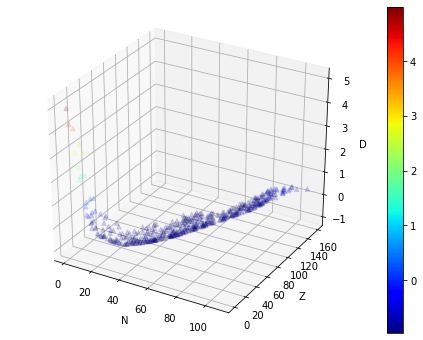

In [33]:
y_new_inverse = y_scaler.inverse_transform(predictions)
x_test_inverse = x_scaler.inverse_transform(X_test)

fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(111,projection='3d')

xs = x_test_inverse[:,0]
ys = x_test_inverse[:,1]
zs = y_new_inverse[:,0]

colmap = cm.ScalarMappable(cmap=cm.get_cmap("jet"))
colmap.set_array(zs)

yg = ax.scatter(xs, ys, zs, c=cm.get_cmap("jet")(zs/max(zs)), marker='^',alpha=0.15)
cb = fig.colorbar(colmap)

ax.set_xlabel('N')
ax.set_ylabel('Z')
ax.set_zlabel('D')


plt.show()

In [ ]:
y_test_o.shape[0]


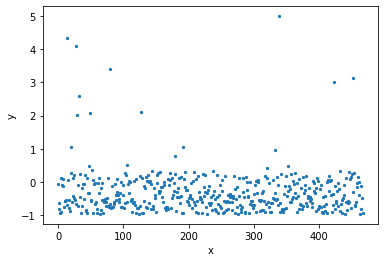

In [34]:
plt.scatter(range(y_new_inverse.shape[0]), y_new_inverse[:,0], s=5)
plt.xlabel('x')
plt.ylabel('y')
plt.axis('tight')
plt.show()

# Plot _first 0th_ column of TEST set

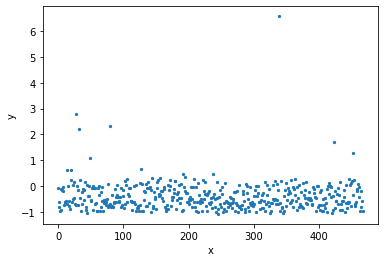

In [35]:
plt.scatter(range(y_test_o.shape[0]), y_test_o, s=5)
plt.xlabel('x')
plt.ylabel('y')
plt.axis('tight')
plt.show()

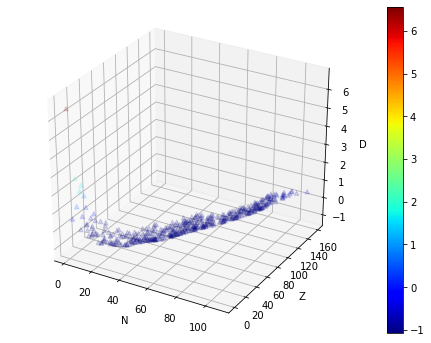

In [36]:
fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(111,projection='3d')

xs = X_test_o[:,0]
ys = X_test_o[:,1]
zs = y_test_o[:,0]

colmap = cm.ScalarMappable(cmap=cm.get_cmap("jet"))
colmap.set_array(zs)

yg = ax.scatter(xs, ys, zs, c=cm.get_cmap("jet")(zs/max(zs)), marker='^',alpha=0.15)
cb = fig.colorbar(colmap)

ax.set_xlabel('N')
ax.set_ylabel('Z')
ax.set_zlabel('D')


plt.show()

# Calculate _diff_ and _diff_abs_ (no distinction for columns)

In [37]:
#diff = np.square((y_new_inverse - y_test_o) / y_test_o)
substraction = y_new_inverse - y_test_o
diff = np.divide( substraction , y_test_o, out = substraction, where = y_test_o != 0)
diff_abs = y_new_inverse - y_test_o

In [39]:
print(diff.shape)
print(diff_abs.shape)

(468, 1)
(468, 1)


In [41]:
diff_df = pd.DataFrame(data={
                            'rel diff mass': diff[:,0],                            
                            'abs diff mass' : diff_abs[:,0]                             
                            })
diff_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 468 entries, 0 to 467
Data columns (total 2 columns):
rel diff mass    468 non-null float64
abs diff mass    468 non-null float64
dtypes: float64(2)
memory usage: 7.4 KB


# Replace inf and -inf with Nan, then drop the nans

In [42]:
diff_df = diff_df.replace([np.inf, -np.inf], np.nan)

In [43]:
print(diff_df.isnull().values.any())
print(diff_df.isnull().sum())
diff_df = diff_df.dropna()

False
rel diff mass    0
abs diff mass    0
dtype: int64


In [44]:
diff_df.describe()

,rel diff mass,abs diff mass
count,468.000000,468.000000
mean,-0.192547,0.081913
std,4.406440,0.272677
min,-70.892491,-1.575391
25%,-0.140759,0.009618
50%,-0.038596,0.033325
75%,0.006995,0.064280
max,24.627060,3.746998


# Plot the relative diff of the first column

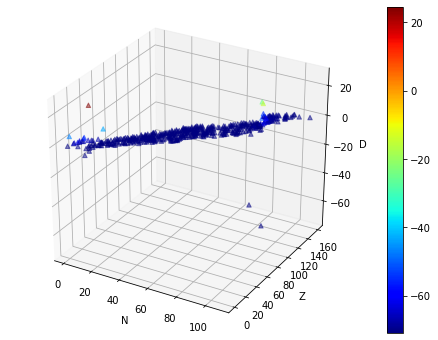

In [45]:
fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(111,projection='3d')

xs = x_test_inverse[:,0]
ys = x_test_inverse[:,1]
zs = diff_df['rel diff mass']# diff[:,0]

colmap = cm.ScalarMappable(cmap=cm.get_cmap("jet"))
colmap.set_array(zs)

yg = ax.scatter(xs, ys, zs, c=cm.get_cmap("jet")(zs/max(zs)), marker='^',alpha=0.5)
cb = fig.colorbar(colmap)

ax.set_xlabel('N')
ax.set_ylabel('Z')
ax.set_zlabel('D')


plt.show()

In [46]:
#%matplotlib notebook

In [47]:
vals = diff_df['rel diff mass'].to_numpy()
print(vals.shape)
print(vals.shape[0])

(468,)
468


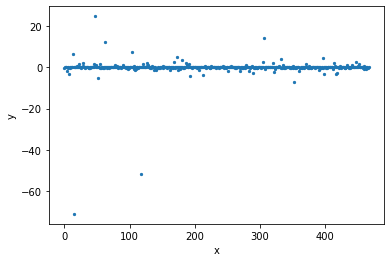

In [48]:
#plt.scatter(iterate_x, diff[:,0], s=5)

plt.scatter(range(vals.shape[0]),vals, s=5)
plt.xlabel('x')
plt.ylabel('y')
plt.axis('tight')
plt.show()

# Diff ABSOLUTE of first column

In [49]:
vals = diff_df['abs diff mass'].to_numpy()
print(vals.shape)
range_x = range(vals.shape[0])

(468,)


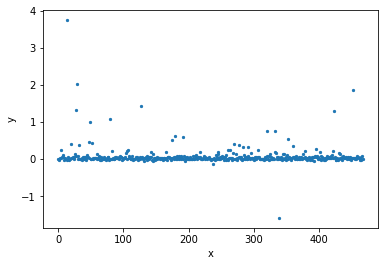

In [50]:
plt.scatter(range_x,vals, s=5)
plt.xlabel('x')
plt.ylabel('y')
plt.axis('tight')
plt.show()